In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import networkx as nx


In [14]:
df = pd.read_csv("Preprocess/DonorKey/donor_key_genes_expression.csv", index_col=0)
print("Shape of dataset:", df.shape)
print(df)

Shape of dataset: (1000, 23)
                                         CD14  CD19      CD3D      CD3E  \
index                                                                     
AAACCTGAGAACAATC-1-IN_NIB_B001_L001  0.000000   0.0  2.346133  1.212320   
AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001  0.000000   0.0  1.428295  2.997206   
AAACCTGAGCAAATCA-1-IN_NIB_B001_L001  0.000000   0.0  0.000000  2.689799   
AAACCTGAGCTAGCCC-1-IN_NIB_B001_L001  0.000000   0.0  0.000000  0.000000   
AAACCTGAGTGTACCT-1-IN_NIB_B001_L001  0.000000   0.0  2.833213  2.001480   
...                                       ...   ...       ...       ...   
AGACGTTCAGACAGGT-1-IN_NIB_B001_L001  1.515931   0.0  0.000000  0.000000   
AGACGTTCATGACATC-1-IN_NIB_B001_L001  0.000000   0.0  0.000000  2.398502   
AGACGTTCATGTCGAT-1-IN_NIB_B001_L001  0.000000   0.0  2.493444  2.128461   
AGACGTTGTAAGTTCC-1-IN_NIB_B001_L001  0.000000   0.0  1.390434  2.777760   
AGACGTTGTGATGATA-1-IN_NIB_B001_L001  0.000000   0.0  1.326894  1.326894

In [15]:
# 2. Check for zeros, NaNs, and infinite values
zero_values = (df == 0).sum().sum()  # Count of zeros in the dataset
nan_values = df.isna().sum().sum()  # Count of NaNs in the dataset
inf_values = (df == np.inf).sum().sum()  # Count of infinities in the dataset

print(f"Zero values: {zero_values}")
print(f"NaN values: {nan_values}")
print(f"Infinity values: {inf_values}")


Zero values: 18613
NaN values: 0
Infinity values: 0


Adding Epsilon creates noise
However...

Using Epsilon (1e-10) for Zero Replacements:
- This is a common and accepted technique in many bioinformatics and ML workflows, especially when working with probability distributions, logarithmic operations, or distance metrics like:
 - Jensen-Shannon Divergence
 - Kullback-Leibler Divergence
 - Entropy-based measures

Why this will not skew the data:
Tiny value - 1e-10 is minuscule, effectively invisible to most downstream computations unless doing ultra-precise scientific modeling
Relative Impact - Most genes with actual expression levels 1e-5 or even 1e-2, adding 1e-10 to zeros wont change distributions in a meaningful way.
Preserves Sparsity - It allows metrics to work properly while preserving the structure of "almost zero" values.
Standard Practice - This is standard for smoothing and handling zeroes in scRNA-seq, RNA-seq, and gene expression matrices before divergence or normalization calculations.

In [24]:
# 3. Filter out rows where total expression is zero
valid_rows = df.sum(axis=1) != 0
filtered_df = df[valid_rows]

# 4. Replace zeros with epsilon while keeping non-zero values
epsilon = 1e-10
df_with_epsilon = filtered_df.copy()

# Replace only zero values with epsilon
df_with_epsilon[df_with_epsilon == 0] = epsilon

# 5. Normalize to probability distributions
normalized_df = df_with_epsilon.div(df_with_epsilon.sum(axis=1), axis=0)

# 6. Add epsilon flag to the dataframe for future reference amd labels for column
epsilon_flag = (filtered_df == 0).any(axis=1)  # True if any value in the row was zero
df_with_epsilon['epsilon_flag'] = epsilon_flag
df_with_epsilon['labels'] = 0  # Since these are healthy donors, we mark all as 0

# Optional: Print rows with epsilon applied
print(f"Rows with epsilon applied:\n{df_with_epsilon[df_with_epsilon['epsilon_flag'] == True]}")

# 7. Compute JSD Matrix (Jensen-Shannon Divergence)
donors = normalized_df.index
n = len(donors)
jsd_matrix = np.zeros((n, n))

gene_contributions = {}  # Dictionary to store gene contributions for each pair

for i in range(n):
    for j in range(i + 1, n):
        jsd = jensenshannon(normalized_df.iloc[i], normalized_df.iloc[j]) ** 2
        jsd_matrix[i, j] = jsd_matrix[j, i] = jsd

         # Calculate the gene expression difference (contribution to JSD)
        gene_diff = np.abs(normalized_df.iloc[i] - normalized_df.iloc[j])
        gene_contributions[(donors[i], donors[j])] = gene_diff.nlargest(5)  # Top 5 contributing genes

# Show the final DataFrame with epsilon inserted
print(df_with_epsilon)


Rows with epsilon applied:
                                             CD14          CD19          CD3D  \
index                                                                           
AAACCTGAGAACAATC-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  2.346133e+00   
AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  1.428295e+00   
AAACCTGAGCAAATCA-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  1.000000e-10   
AAACCTGAGCTAGCCC-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  1.000000e-10   
AAACCTGAGTGTACCT-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  2.833213e+00   
...                                           ...           ...           ...   
AGACGTTCAGACAGGT-1-IN_NIB_B001_L001  1.515931e+00  1.000000e-10  1.000000e-10   
AGACGTTCATGACATC-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  1.000000e-10   
AGACGTTCATGTCGAT-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  2.493444e+00   
AGACGTTGTAAGTTCC-1-IN_NIB_B001_L001  1.000000e-10  1.000000e-10  1.390434e+00   
A

In [17]:
donor_pair = (donors[0], donors[1])
print(f"Plotting gene expression distributions for donor pair: {donor_pair}")

Plotting gene expression distributions for donor pair: ('AAACCTGAGAACAATC-1-IN_NIB_B001_L001', 'AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001')


In [26]:
# Plot gene contributions for the selected donor pair
top_genes_for_pair = gene_contributions[donor_pair]
print(f"Top contributing genes for {donor_pair}:")
print(top_genes_for_pair)


Top contributing genes for ('AAACCTGAGAACAATC-1-IN_NIB_B001_L001', 'AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001'):
NKG7     0.335698
CD3D     0.192969
CD69     0.169064
CD8A     0.156207
KLRD1    0.109328
dtype: float64


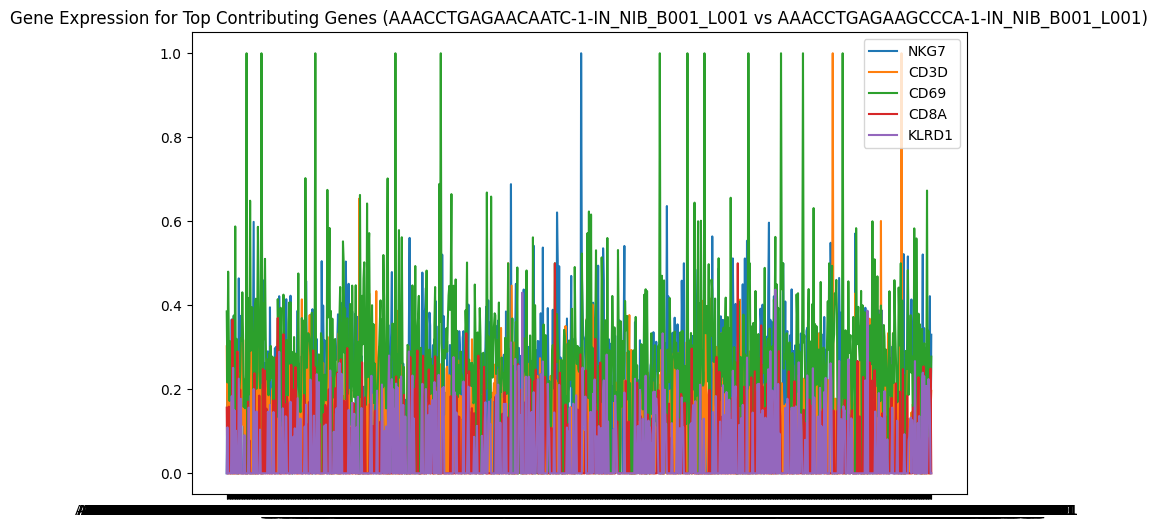

In [27]:
# Visualize the gene expression for the top contributing genes
plt.figure(figsize=(10, 6))
for gene in top_genes_for_pair.index:
    plt.plot(normalized_df[gene], label=gene)
plt.title(f"Gene Expression for Top Contributing Genes ({donor_pair[0]} vs {donor_pair[1]})")
plt.legend(loc="best")
plt.show()

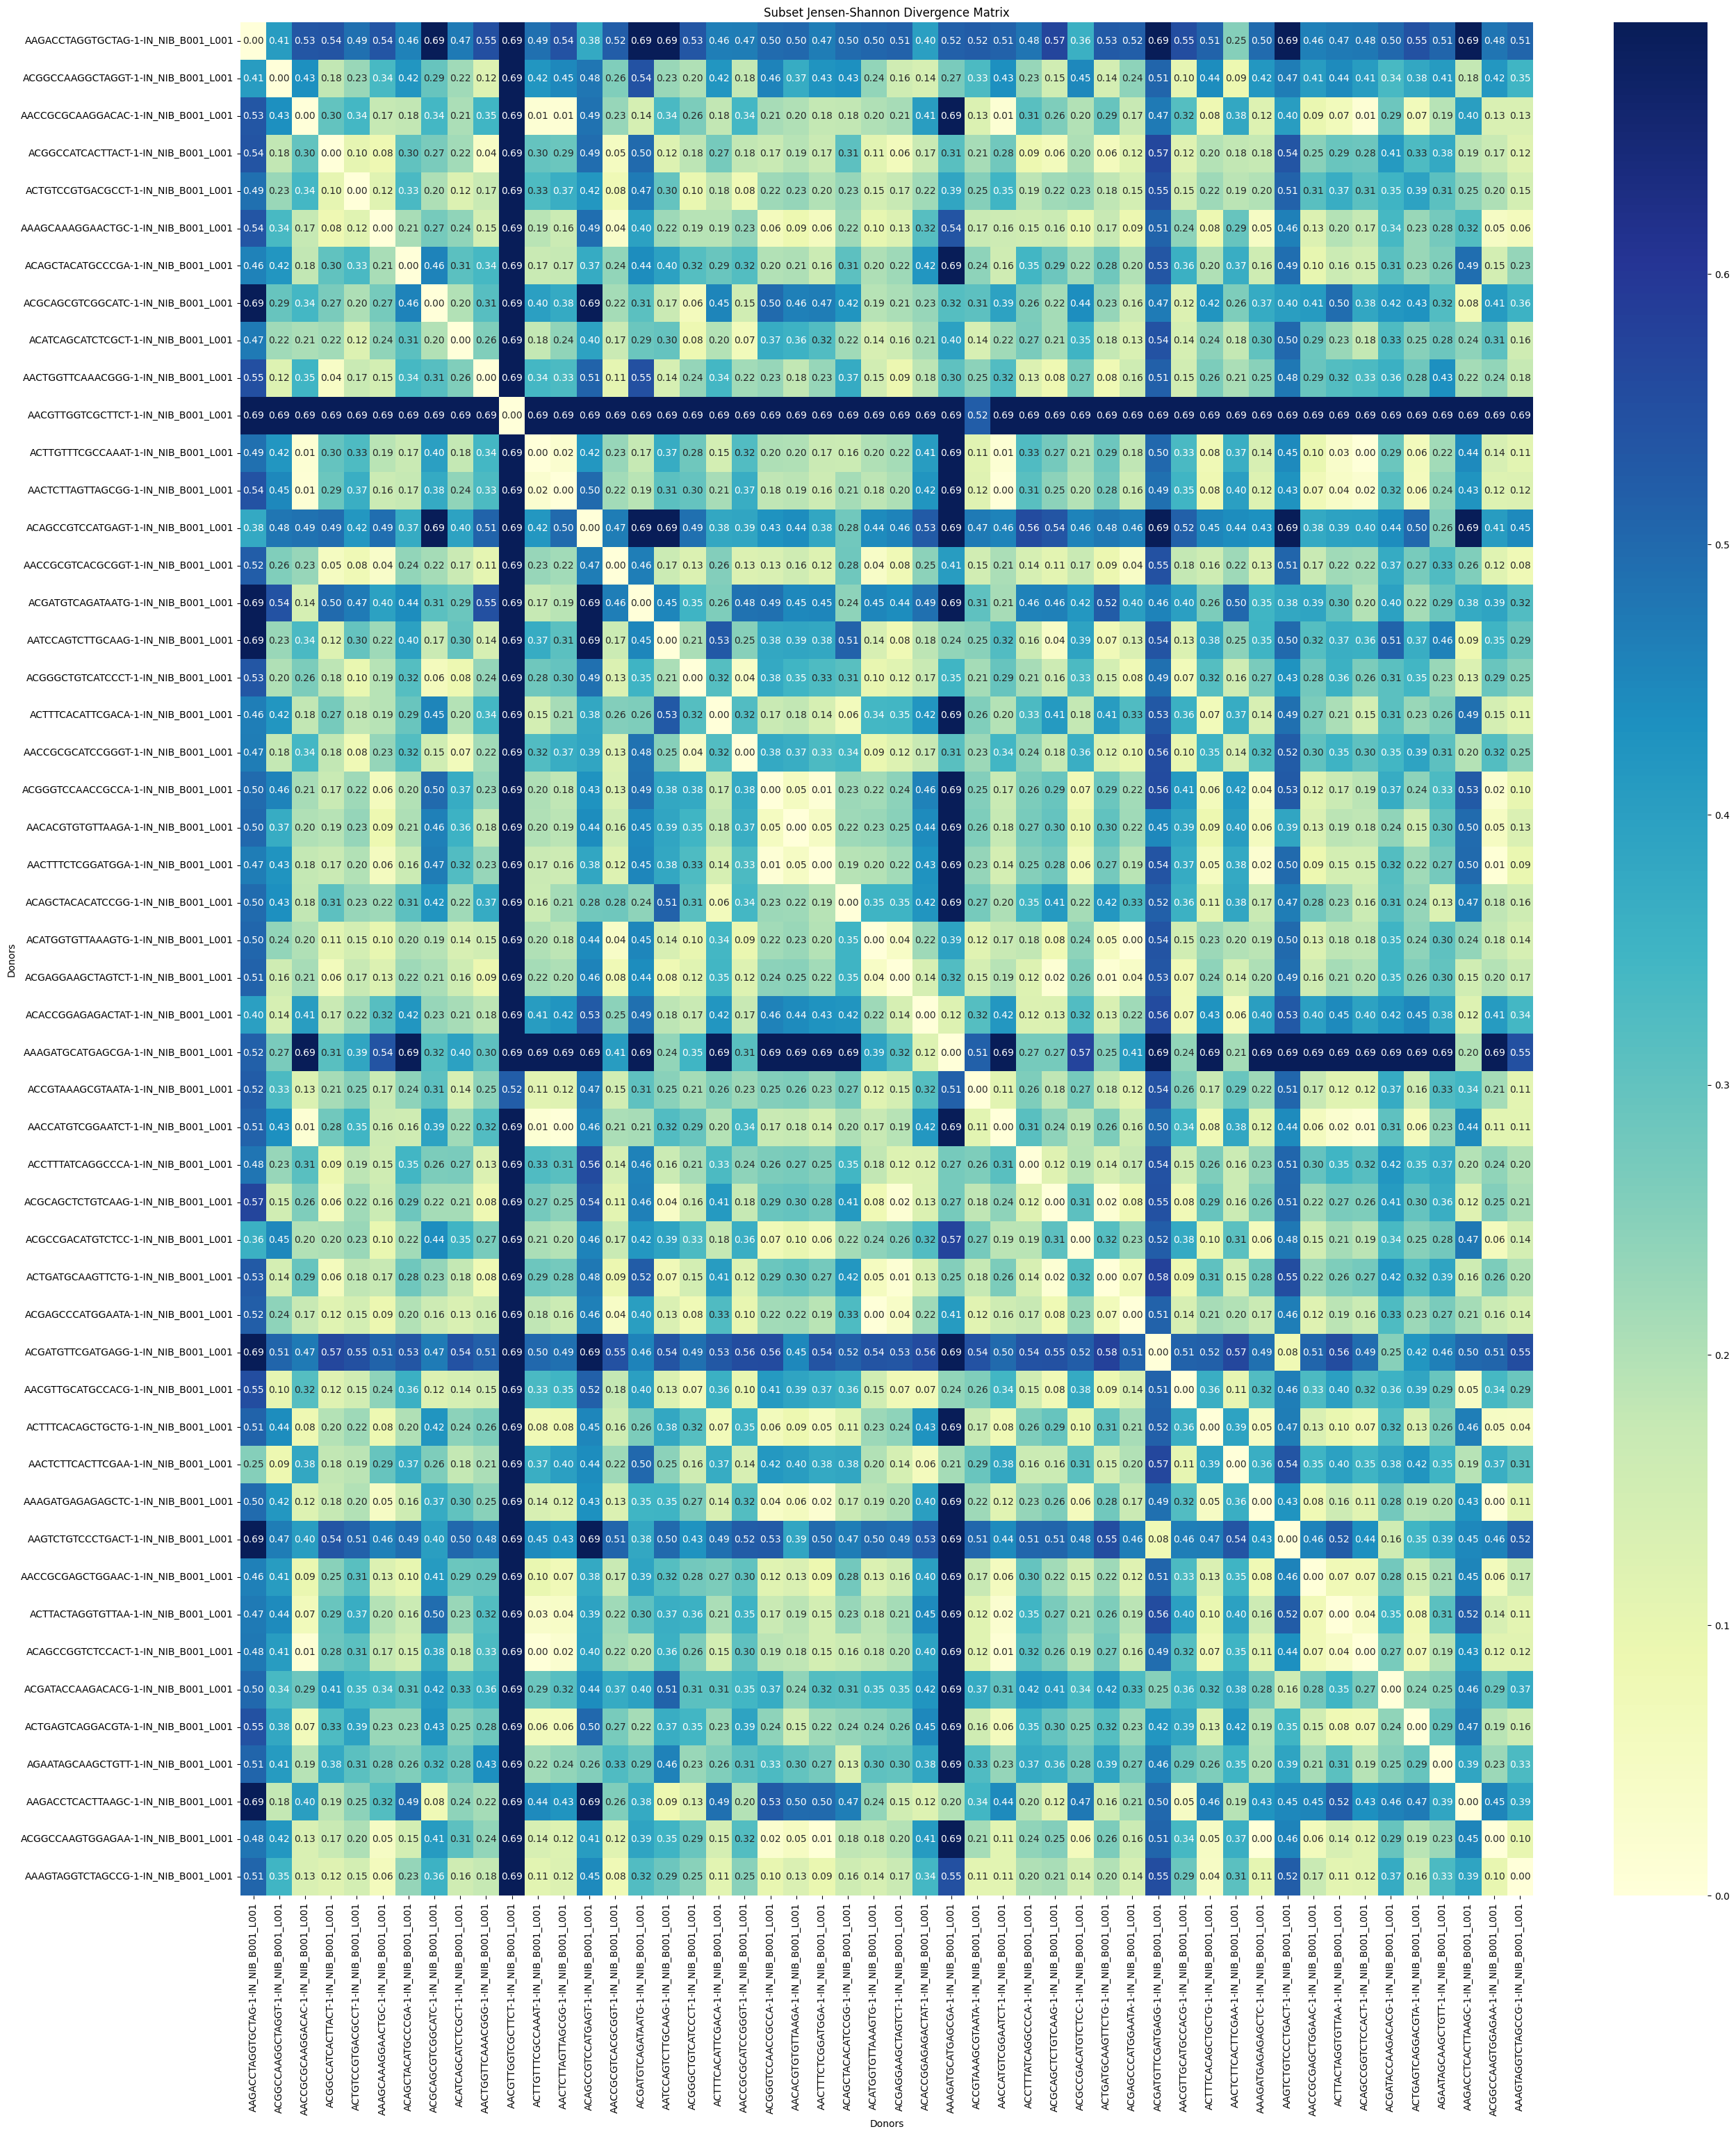

In [18]:
# Select a random subset of donors (e.g., 50 samples)
subset_indices = np.random.choice(len(donors), size=50, replace=False)  # Randomly select indices
subset_donors = [donors[i] for i in subset_indices]  # Get donor names based on the indices

# Slice the Jensen-Shannon Divergence matrix using the chosen indices
subset_jsd_matrix = jsd_matrix[np.ix_(subset_indices, subset_indices)]  # Correctly index rows and columns

# Now plot the heatmap for this smaller subset
plt.figure(figsize=(30, 35))
sns.heatmap(subset_jsd_matrix, cmap='YlGnBu', annot=True, fmt='.2f', xticklabels=subset_donors, yticklabels=subset_donors)
plt.title('Subset Jensen-Shannon Divergence Matrix')
plt.xlabel('Donors')
plt.ylabel('Donors')
plt.show()


In [19]:
# Show the final DataFrame with epsilon inserted and labels added
print(df_with_epsilon.shape)
print(df_with_epsilon.columns[:5])
print(df_with_epsilon.index[:5])


(995, 25)
Index(['CD14', 'CD19', 'CD3D', 'CD3E', 'CD4'], dtype='object')
Index(['AAACCTGAGAACAATC-1-IN_NIB_B001_L001',
       'AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001',
       'AAACCTGAGCAAATCA-1-IN_NIB_B001_L001',
       'AAACCTGAGCTAGCCC-1-IN_NIB_B001_L001',
       'AAACCTGAGTGTACCT-1-IN_NIB_B001_L001'],
      dtype='object', name='index')


In [20]:
!pip install shap
!pip install xgboost


In [21]:
print(df_with_epsilon.shape)
print(df_with_epsilon.columns[:5])
print(df_with_epsilon.index[:5])


(995, 25)
Index(['CD14', 'CD19', 'CD3D', 'CD3E', 'CD4'], dtype='object')
Index(['AAACCTGAGAACAATC-1-IN_NIB_B001_L001',
       'AAACCTGAGAAGCCCA-1-IN_NIB_B001_L001',
       'AAACCTGAGCAAATCA-1-IN_NIB_B001_L001',
       'AAACCTGAGCTAGCCC-1-IN_NIB_B001_L001',
       'AAACCTGAGTGTACCT-1-IN_NIB_B001_L001'],
      dtype='object', name='index')


In [28]:
import pickle

labels = df_with_epsilon['labels'].values
np.save('labels.npy', labels)

# Create a graph from the JSD matrix
G = nx.Graph()

# Add nodes to the graph (representing the donors)
donors = df.index.tolist()  # Assuming donors are represented by row indices or a column
G.add_nodes_from(donors)

# Add edges with weights (JSD values)
for i in range(n):
    for j in range(i + 1, n):
        G.add_edge(donors[i], donors[j], weight=jsd_matrix[i, j])


# Save the graph (optional, if you want to visualize it later)
with open('jsd_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

# Save the adjacency matrix (for use in the second notebook)
np.save('adj_matrix.npy', jsd_matrix.astype(np.float32))

# Save the gene expression data as node features (for use in the second notebook)
np.save('node_features.npy', df_with_epsilon.values.astype(np.float32))
